In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataloaders
import models
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics 
import sklearn.cluster as cluster
import numpy as np 
import random
import classifiers
from torch.autograd import Variable
import torch
import torch.nn as nn 
import torch.optim as optim
import sklearn.model_selection as model_selection
import util
import json
from collections import defaultdict
import pathlib
import pickle
from collections import defaultdict

from imblearn.under_sampling import RandomUnderSampler

Using Theano backend.


In [3]:
def random_sample(X, y, ratio=0.2):
    if ratio != 1.0:
        num_elems = len(X)
        indicies = list(range(0, num_elems))
        sampled_indicies = random.sample(indicies, int(ratio * num_elems))
        sampled_indicies = np.array(sampled_indicies)
        X_sampled = X[sampled_indicies,:]
        y_sampled = y[sampled_indicies]
        return X_sampled, y_sampled
    return X, y

In [4]:
num_samples_per = 1
sample_ratios = [0.6, 0.8, 1.0]
num_splits = 5
first = 102
last = 107
house_sitting_numbers = range(first, last + 1)
input_data_path = pathlib.Path('../data/house')
delimiter = ','

In [42]:
# paramaters shared by all models
#num_nodes = data.get_num_nodes()
dims = 8
epochs = 5
lr = 0.1
lr_decay=0.0
weight_decay=0.0
lam = 0.00055
p = 2

# parameters specific to SiNE
delta = 1
delta0 = 0.8
dims_array = [dims, 20, 20]
frac1 = 0.5
frac0 = 0
p0 = True if frac0 > 0 else 0

In [43]:
results = defaultdict(dict)

for house_num in house_sitting_numbers:
    edgelist_file = f'house-{house_num}-cleaned.csv'
    classes_file = f'house-{house_num}-classes.csv'
    
    print(f'Considering house #{house_num} dataset')
    edgelist_path = input_data_path / edgelist_file
    classes_path = input_data_path / classes_file
    data = dataloaders.SenateDataset(str(edgelist_path), str(classes_path), ratio=0.9)
    X, y = data.get_shuffled_data()
    stem = []
    sine = []
    sdne = []
    results[house_num]['stem'] = stem
    results[house_num]['sine'] = sine
    results[house_num]['sdne'] = sdne
    num_nodes = data.get_num_nodes()
    X, y = data.get_shuffled_data()
    triples, triples0 = util.triples_from_array(X, y)
    batch_size = int(frac1 * len(X))
    batch_size0 = int(frac0 * len(triples0))
    kf = model_selection.KFold(n_splits=num_splits)
    node_names = np.arange(0, num_nodes) + 1
    node_classes = np.array(data.get_node_classes())
    node_names = node_names[node_classes < 2]
    node_classes = node_classes[node_classes < 2]
    kf.get_n_splits(node_names)
#     kernel_model = models.fit_pseudo_kernel_model(num_nodes, dims, X, y, epochs=epochs, p=p, 
#                                               lr=lr,lr_decay=lr_decay, lam=lam, weight_decay=weight_decay, undersample=False)
#     sine_model = models.fit_sine_model(num_nodes, dims_array, triples, triples0, delta, delta0,
#                                    batch_size, batch_size0, epochs, lr=lr, lr_decay=lr_decay,
#                                   lam=lam, p=p, p0=p0)
    print('Training SDNE')
    sdne_model = models.fit_sdne(dims, num_nodes, X, epochs, batch_size)
    for node_train_idx, node_test_idx in kf.split(node_names):
        
        node_X_train, node_y_train = node_names[node_train_idx], node_classes[node_train_idx]
        node_X_test, node_y_test = node_names[node_test_idx], node_classes[node_test_idx]
        
        # train and eval SDNE
        sdne_clf = linear_model.LogisticRegression()
        clf = sdne_clf
        model = sdne_model
        report = classifiers.train_and_evaluate_node_classifier(clf, model, node_X_train, node_y_train, 
                                                                        node_X_test, node_y_test)
        sdne.append(report)
                
#         # train and evaluate StEM model
        
#         kernel_clf = linear_model.LogisticRegression()
#         clf = kernel_clf
#         model = kernel_model
#         report = classifiers.train_and_evaluate_node_classifier(clf, model, 
#                                                                         node_X_train, node_y_train, 
#                                                                         node_X_test, node_y_test)
#         stem.append(report)
#         #print(report)
                
#         # train and evaluate SiNE model
                
        
#         clf_sine = linear_model.LogisticRegression()
#         clf = clf_sine
#         model = sine_model
#         report = classifiers.train_and_evaluate_node_classifier(clf, model, 
#                                                                         node_X_train, node_y_train, 
#                                                                         node_X_test, node_y_test)
#         sine.append(report)
        
                
        print(results[house_num])
    
    
            
            
    
    
    

Considering house #102 dataset
Training SDNE
442


/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:71: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y[i])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:71: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y[i])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:73: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y[K - 1])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:75: UserWarning: Update your `Model` call to the 

Epoch 1/5
2/2 [==============================] - 30s - loss: 44.0817 - merge_133_loss: 22.0308 - merge_134_loss: 22.0308 - merge_135_loss: 0.0105     
Epoch 2/5
2/2 [==============================] - 21s - loss: 77.6447 - merge_133_loss: 38.8124 - merge_134_loss: 38.8117 - merge_135_loss: 0.0110      
Epoch 3/5
2/2 [==============================] - 20s - loss: 48.8472 - merge_133_loss: 24.4119 - merge_134_loss: 24.4119 - merge_135_loss: 4.9021e-05    
Epoch 4/5
2/2 [==============================] - 18s - loss: 47.1677 - merge_133_loss: 23.5700 - merge_134_loss: 23.5700 - merge_135_loss: 3.2954e-05    
Epoch 5/5
2/2 [==============================] - 17s - loss: 44.4457 - merge_133_loss: 22.2063 - merge_134_loss: 22.2063 - merge_135_loss: 7.5288e-05    
[[ 0.          0.          0.18498971 ...,  0.          0.          0.        ]
 [ 0.          0.          1.10042167 ...,  0.          0.          0.        ]
 [ 0.          0.          1.11496675 ...,  0.          0.          0.     

/Users/inzamamrahaman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training SDNE
443


/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_136, outputs=Elemwise{m...)`
  encoder = Model(input=x, output=y[K])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:92: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(443, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y_hat[1])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_137, outputs=Elemwise{m...)`
  decoder = Model(input=y, output=x_hat)
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_138, outpu

Epoch 1/5
2/2 [==============================] - 20s - loss: 40.3533 - merge_136_loss: 20.1666 - merge_137_loss: 20.1666 - merge_138_loss: 0.0140     
Epoch 2/5
2/2 [==============================] - 16s - loss: 124.0214 - merge_136_loss: 61.9995 - merge_137_loss: 61.9995 - merge_138_loss: 0.0117      
Epoch 3/5
2/2 [==============================] - 17s - loss: 152.5602 - merge_136_loss: 76.2637 - merge_137_loss: 76.2629 - merge_138_loss: 0.0039       
Epoch 4/5
2/2 [==============================] - 27s - loss: 49.6852 - merge_136_loss: 24.8142 - merge_137_loss: 24.8142 - merge_138_loss: 0.0000e+00    
Epoch 5/5
2/2 [==============================] - 21s - loss: 49.1943 - merge_136_loss: 24.5518 - merge_137_loss: 24.5518 - merge_138_loss: 0.0000e+00    
[[ 0.          0.00143939  0.         ...,  0.          0.          0.        ]
 [ 0.          0.00143939  0.         ...,  0.          0.          0.        ]
 [ 0.          0.00143939  0.         ...,  0.          0.          0.    

/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_139, outputs=Elemwise{m...)`
  encoder = Model(input=x, output=y[K])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:92: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(446, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y_hat[1])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_140, outputs=Elemwise{m...)`
  decoder = Model(input=y, output=x_hat)
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_141, outpu

Epoch 1/5
2/2 [==============================] - 29s - loss: 47.1341 - merge_139_loss: 23.5570 - merge_140_loss: 23.5570 - merge_141_loss: 0.0071     
Epoch 2/5
2/2 [==============================] - 21s - loss: 49.4049 - merge_139_loss: 24.6922 - merge_140_loss: 24.6925 - merge_141_loss: 0.0157     
Epoch 3/5
2/2 [==============================] - 21s - loss: 49.1054 - merge_139_loss: 24.5424 - merge_140_loss: 24.5424 - merge_141_loss: 0.0000e+00    
Epoch 4/5
2/2 [==============================] - 21s - loss: 47.9081 - merge_139_loss: 23.9429 - merge_140_loss: 23.9429 - merge_141_loss: 0.0000e+00     
Epoch 5/5
2/2 [==============================] - 25s - loss: 46.0275 - merge_139_loss: 23.0014 - merge_140_loss: 23.0014 - merge_141_loss: 0.0000e+00     
[[ 0.          0.          0.01767363 ...,  0.          0.          0.02171278]
 [ 0.          0.          0.01767363 ...,  0.          0.          0.02171278]
 [ 0.          0.          0.01767363 ...,  0.          0.          0.0217

/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_142, outputs=Elemwise{m...)`
  encoder = Model(input=x, output=y[K])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:92: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(445, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y_hat[1])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_143, outputs=Elemwise{m...)`
  decoder = Model(input=y, output=x_hat)
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_144, outpu

Epoch 1/5
2/2 [==============================] - 37s - loss: 40.5818 - merge_142_loss: 20.2807 - merge_143_loss: 20.2809 - merge_144_loss: 0.0154     
Epoch 2/5
2/2 [==============================] - 18s - loss: 69.7410 - merge_142_loss: 34.8604 - merge_143_loss: 34.8603 - merge_144_loss: 0.0180    
Epoch 3/5
2/2 [==============================] - 17s - loss: 42.2918 - merge_142_loss: 21.1350 - merge_143_loss: 21.1350 - merge_144_loss: 0.0016    
Epoch 4/5
2/2 [==============================] - 18s - loss: 84.8603 - merge_142_loss: 42.4169 - merge_143_loss: 42.4172 - merge_144_loss: 0.0039     
Epoch 5/5
2/2 [==============================] - 18s - loss: 48.2822 - merge_142_loss: 24.1239 - merge_143_loss: 24.1239 - merge_144_loss: 0.0000e+00    
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
{'stem': [], 'sine': [], 'sdne': [{'micro_f1

/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_145, outputs=Elemwise{m...)`
  encoder = Model(input=x, output=y[K])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:92: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(441, activation="relu", kernel_regularizer=<keras.reg...)`
  W_regularizer=Reg.l1_l2(l1=nu1, l2=nu2))(y_hat[1])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_146, outputs=Elemwise{m...)`
  decoder = Model(input=y, output=x_hat)
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_147, outpu

Epoch 1/5
2/2 [==============================] - 19s - loss: 41.3418 - merge_145_loss: 20.6608 - merge_146_loss: 20.6609 - merge_147_loss: 0.0215     
Epoch 2/5
2/2 [==============================] - 16s - loss: 41.0156 - merge_145_loss: 20.4977 - merge_146_loss: 20.4978 - merge_147_loss: 0.0129    
Epoch 3/5
2/2 [==============================] - 17s - loss: 46.5108 - merge_145_loss: 23.2453 - merge_146_loss: 23.2454 - merge_147_loss: 0.0017    
Epoch 4/5
2/2 [==============================] - 18s - loss: 96.9561 - merge_145_loss: 48.4681 - merge_146_loss: 48.4675 - merge_147_loss: 0.0063    
Epoch 5/5
2/2 [==============================] - 16s - loss: 47.0256 - merge_145_loss: 23.5006 - merge_146_loss: 23.5006 - merge_147_loss: 0.0000e+00    
[[ 0.04192768  0.          0.         ...,  0.          0.          0.0012213 ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ...,

/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_148, outputs=Elemwise{m...)`
  encoder = Model(input=x, output=y[K])
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_149, outputs=Elemwise{m...)`
  decoder = Model(input=y, output=x_hat)
/Users/inzamamrahaman/.local/lib/python3.6/site-packages/gem-1.0.0-py3.6.egg/gem/embedding/sdne_utils.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_150, outputs=[Elemwise{...)`
  autoencoder = Model(input=x, output=[x_hat, y])


Epoch 1/5
2/2 [==============================] - 18s - loss: 40.7941 - merge_148_loss: 20.3870 - merge_149_loss: 20.3870 - merge_150_loss: 0.0191     
Epoch 2/5
2/2 [==============================] - 15s - loss: 45.8685 - merge_148_loss: 22.9242 - merge_149_loss: 22.9242 - merge_150_loss: 0.0080    
Epoch 3/5
2/2 [==============================] - 15s - loss: 115.1512 - merge_148_loss: 57.5650 - merge_149_loss: 57.5660 - merge_150_loss: 0.0123   
Epoch 4/5
2/2 [==============================] - 15s - loss: 47.2824 - merge_148_loss: 23.6280 - merge_149_loss: 23.6280 - merge_150_loss: 3.1614e-04    
Epoch 5/5
2/2 [==============================] - 15s - loss: 47.9701 - merge_148_loss: 23.9659 - merge_149_loss: 23.9664 - merge_150_loss: 0.0038    
[[ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 ...,

In [44]:
import json

In [45]:
fp = open('nclasssdne.json', 'w')
json.dump(results, fp)
fp.close()

In [46]:
from sklearn.manifold import TSNE, MDS, SpectralEmbedding

In [52]:
kernel_tsne = SpectralEmbedding(n_components=2, n_neighbors=len(data.get_node_classes()) // 2)
sdne_tsne = SpectralEmbedding(n_components=2, n_neighbors=len(data.get_node_classes()) // 2)
w = sdne_model.get_all_weights()[:,:]
print(w)
kproj = sdne_tsne.fit_transform(w)
print(kproj)

#sproj = sine_tsne.fit_transform(sine_model.get_all_weights()[1:, :])

[[ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]
 [ 0.20329076  0.          0.         ...,  0.          0.          0.        ]]
[[  3.13053355e-01  -2.54649619e-02]
 [  3.73189177e-01   2.01061912e-02]
 [ -1.95777957e+00  -1.86681171e-02]
 [  1.45192405e-01  -3.17143576e-02]
 [ -8.79356610e-01   1.82426539e-01]
 [ -6.51805776e-02  -3.19258331e-02]
 [  2.20416085e-01   9.36542692e-01]
 [ -4.81891702e-01  -8.56519217e-02]
 [ -7.13436454e-01   1.17520903e+00]
 [  4.56674840e-01  -8.51695382e-02]
 [  2.40607837e-01   8.51496755e-01]
 [  2.99241729e-01  -2.52869551e-01]
 [ -4.24350768e-01  -4.28698534e-02]
 [ -7.04572639e-01  -1.72175731

In [53]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

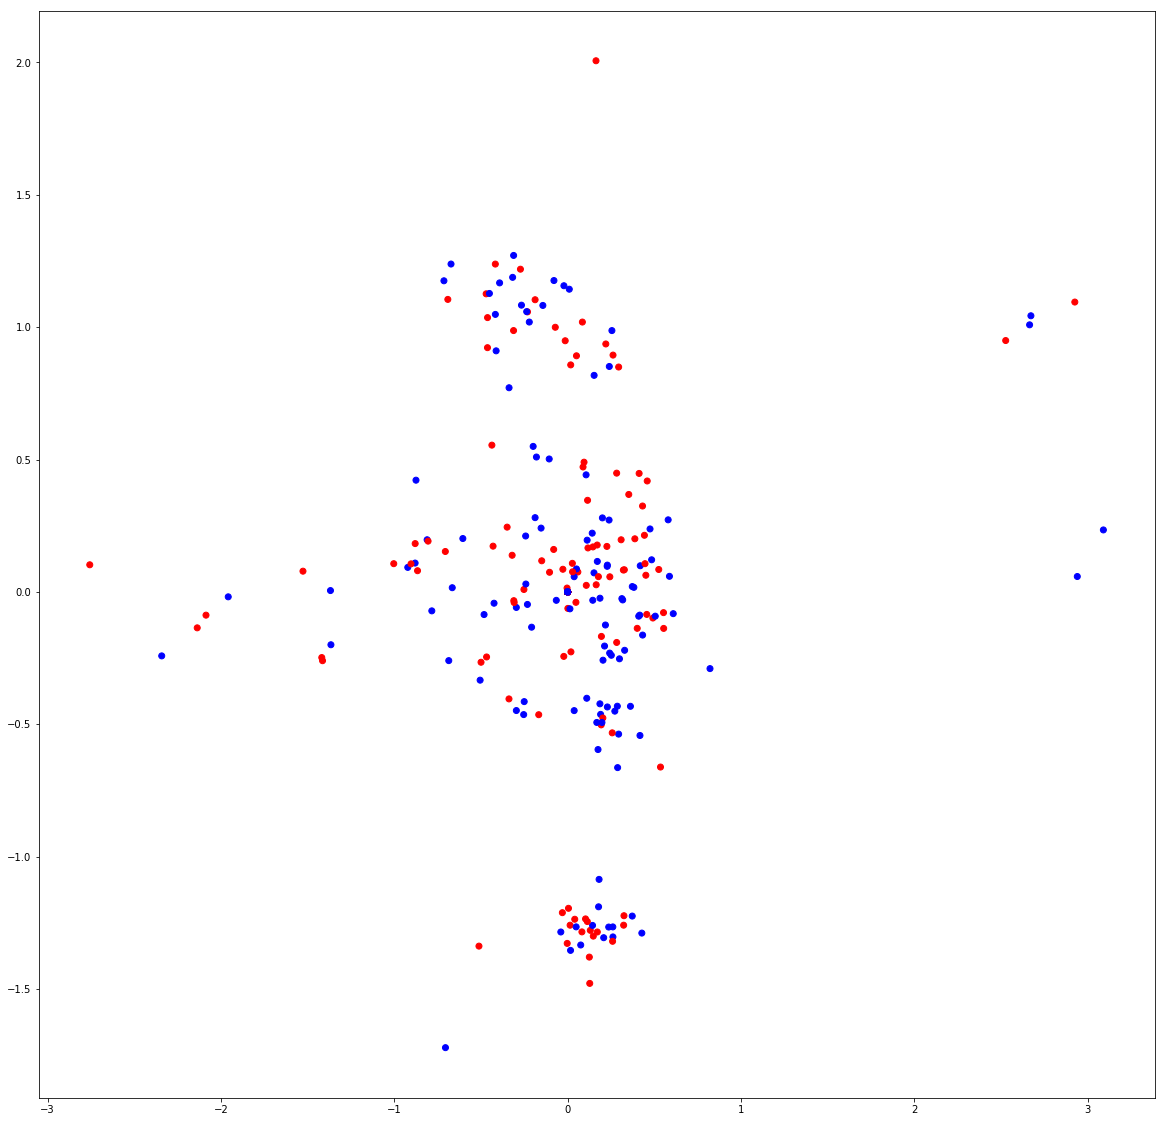

In [54]:
plt.scatter(kproj[:,0], kproj[:,1], c=['blue' if x == 0 else ('red'  if x == 1  else 'green') for x in data.get_node_classes()])

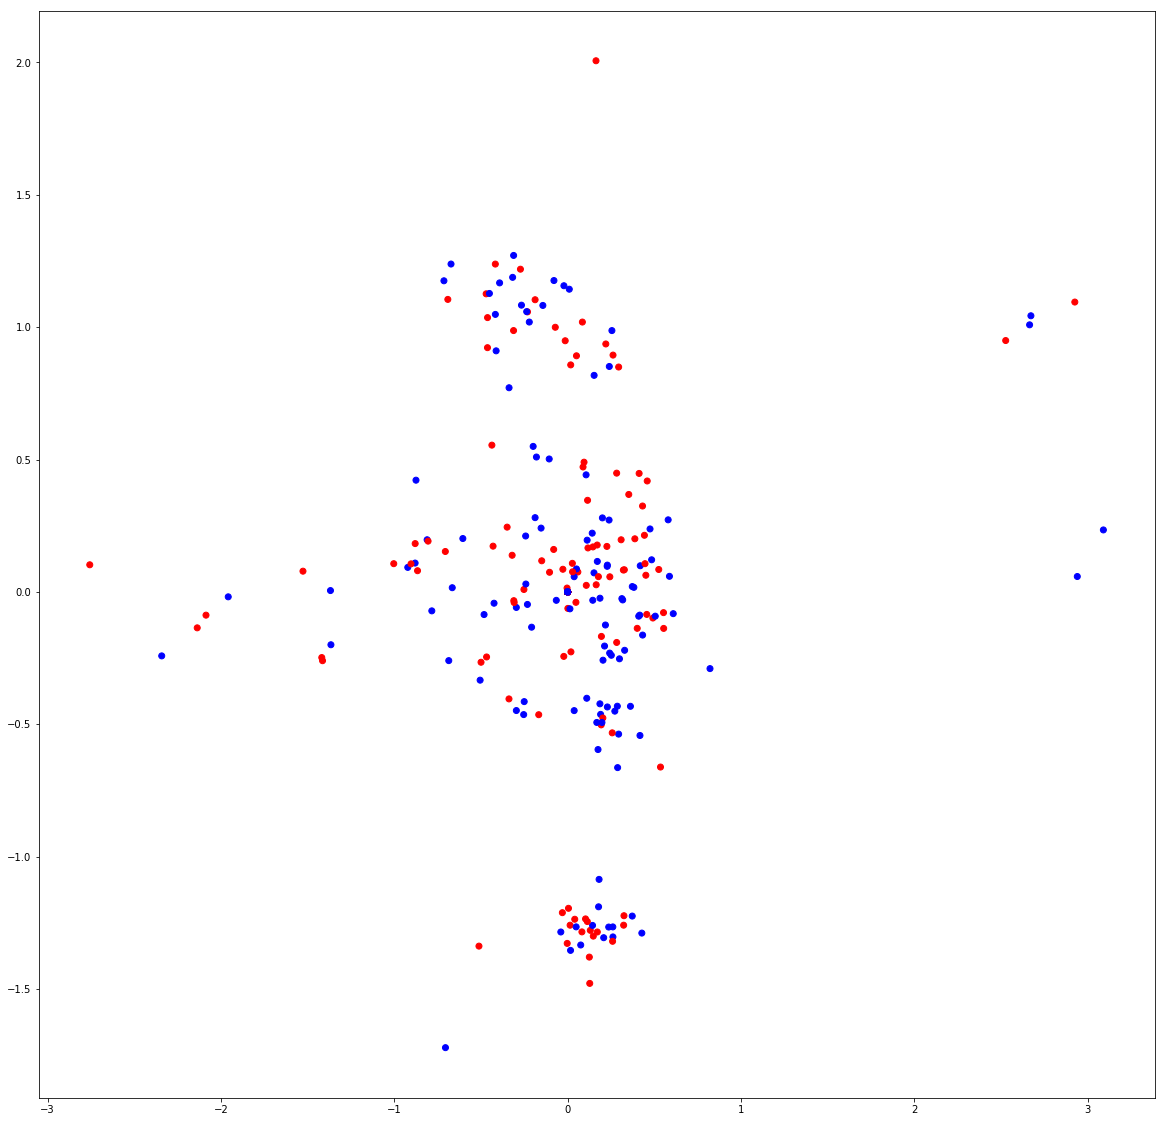

In [55]:
plt.scatter(kproj[:,0], kproj[:,1], c=['blue' if x == 0 else ('red'  if x == 1  else 'green') for x in data.get_node_classes()])

In [77]:
kernel_clf.coef_

array([[-0.50058401,  1.82814468, -1.48973712, -0.96361279,  1.3486263 ,
         1.30543107, -1.02604172,  1.24738153]])

In [78]:
clf = linear_model.LogisticRegression()
clf.fit(kproj, data.get_node_classes())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
clf.coef_

array([[ 0.1303311 ,  0.47440052],
       [-0.23174195, -0.38035313],
       [ 0.01901688, -0.0101354 ]])

In [57]:
clf.predict(kproj) - data.get_node_classes()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [58]:
kproj

array([[ -0.55150592,  17.24842072],
       [ 15.85057926,  15.07833862],
       [ 18.45259094,  10.58271408],
       [ 18.05149078,  11.31574345],
       [-15.41981983,   4.05870914],
       [ -1.63427031,  16.9121685 ],
       [  7.52314425, -22.52648163],
       [  9.57038021,  14.20941734],
       [ 21.29135704,   8.36176777],
       [ -8.6380558 , -16.16506386],
       [ 21.07715416,   6.57645655],
       [ 23.74251366,   5.10992956],
       [ -7.61885309,  15.05415058],
       [ 20.32995605,   8.42292118],
       [-15.60592747,   3.09431076],
       [-14.08902264,  -8.2098999 ],
       [ 11.7697897 ,  15.07514286],
       [ 14.51570129,  14.48489857],
       [ -7.6244669 , -17.78199005],
       [ 20.67331505,   7.71188307],
       [ -7.17330885,  14.22305107],
       [ 22.13213921,   7.32073689],
       [ -9.35598373, -15.17517185],
       [  3.84687901, -22.08554459],
       [  9.60978317, -24.87771988],
       [  3.11245537, -22.12257576],
       [  9.08624458, -24.38124657],
 